In [1]:
import cv2
import numpy as np
import pandas as pd

In [2]:
def get_image_from_file(file_name):
	img = cv2.imread(file_name)
	maskim = cv2.inRange(img, (0, 0, 250), (0, 0, 255))
	img[maskim == 0] = [255, 255, 255]
	# img = cv2.GaussianBlur(img, (5, 5), 0)
	return img

In [10]:
flechas = [get_image_from_file('marcas-capturasStage/Flecha1.png'),
           get_image_from_file('marcas-capturasStage/Flecha2.png'),
           get_image_from_file('marcas-capturasStage/Flecha3.png'),
           get_image_from_file('marcas-capturasStage/Flecha4.png'),
           get_image_from_file('marcas-capturasStage/Flecha5.png')]

man = [get_image_from_file('marcas-capturasStage/man-1.png'),
       get_image_from_file('marcas-capturasStage/man-2.png'),
       get_image_from_file('marcas-capturasStage/man-3.png'),
       get_image_from_file('marcas-capturasStage/man-4.png'),
       get_image_from_file('marcas-capturasStage/man-5.png'),
       get_image_from_file('marcas-capturasStage/man-6.png'),
       get_image_from_file('marcas-capturasStage/man-7.png')]

stairs = [get_image_from_file('marcas-capturasStage/stairs-1.png'),
          get_image_from_file('marcas-capturasStage/stairs-2.png'),
          get_image_from_file('marcas-capturasStage/stairs-3.png'),
          get_image_from_file('marcas-capturasStage/stairs-4.png'),
          get_image_from_file('marcas-capturasStage/stairs-5.png'),
          get_image_from_file('marcas-capturasStage/stairs-6.png'),
          get_image_from_file('marcas-capturasStage/stairs-7.png')]

telephone = [get_image_from_file('marcas-capturasStage/telephone-1.png'),
             get_image_from_file('marcas-capturasStage/telephone-2.png'),
             get_image_from_file('marcas-capturasStage/telephone-3.png'),
             get_image_from_file('marcas-capturasStage/telephone-4.png'),
             get_image_from_file('marcas-capturasStage/telephone-5.png'),
             get_image_from_file('marcas-capturasStage/telephone-6.png'),
             get_image_from_file('marcas-capturasStage/telephone-7.png')]

woman = [get_image_from_file('marcas-capturasStage/woman-1.png'),
         get_image_from_file('marcas-capturasStage/woman-2.png'),
         get_image_from_file('marcas-capturasStage/woman-3.png'),
         get_image_from_file('marcas-capturasStage/woman-4.png'),
         get_image_from_file('marcas-capturasStage/woman-5.png'),
         get_image_from_file('marcas-capturasStage/woman-6.png'),
         get_image_from_file('marcas-capturasStage/woman-7.png')]

# cv2.imshow('Sample', flechas[0])
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1/255.0,
    horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=(0.5, 1.0)
)

train_generator = datagen.flow_from_directory(
    "marcas-capturasStage/",
    target_size=(100, 100),
    batch_size=256,
    seed=1234
)


In [4]:
def extract_features(img):
	img = cv2.cvtColor(img.copy(), cv2.COLOR_RGBA2GRAY)
	img = img - 255

	cont_list_im, hier = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

	# cont_list_im = np.array(cont_list_im)
	# cont_list_im = cont_list_im[np.array([cv2.contourArea(conto) for conto in cont_list_im]) > 10]
	orb = cv2.ORB_create()
	ellip = cv2.fitEllipse(cont_list_im[0])
	cen, ejes, angulo = np.array(ellip[0]), np.array(ellip[1]), ellip[2]
	kp = cv2.KeyPoint(cen[0], cen[1], np.mean(ejes) * 1.3, angulo - 90)
	lkp, des = orb.compute(img, [kp])

	return cont_list_im, ellip, lkp, des

In [ ]:
sample = flechas[0].copy()

contours, ellipse, lkeyp, dess = extract_features(sample)

for cont in contours:
	cv2.drawContours(sample, cont, -1, (np.random.randint(0, 255), np.random.randint(0, 255), 0), 3)

cv2.ellipse(sample, ellipse, (255, 0, 0), 3)
cv2.drawKeypoints(sample, lkeyp, sample, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
cv2.imshow('sample', sample)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [11]:
columns = ['area', 'momentx', 'momenty', 'label', 'm00', 'm10', 'm01', 'm20', 'm11', 'm02', 'm30', 'm21', 'm12', 'm03',
           'mu20', 'mu11', 'mu02', 'mu30', 'mu21', 'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21', 'nu12',
           'nu03']
df = pd.DataFrame(columns=columns)

for arrow in flechas:
	contours, ellipse, lkeyp, dess = extract_features(arrow.copy())
	M_1 = cv2.moments(contours[0])

	if M_1["m00"] == 0: M_1["m00", "m01"] = 1
	x = int(M_1["m10"] / M_1["m00"])
	y = int(M_1["m01"] / M_1["m00"])
	data = {'momentx': x, 'momenty': y, 'area': cv2.contourArea(contours[0]), 'label': 0}
	data.update(M_1)
	df = df.append(data, ignore_index=True)

for m in man:
	contours, ellipse, lkeyp, dess = extract_features(m)
	M_1 = cv2.moments(contours[0])
	if M_1["m00"] == 0: M_1["m00", "m01"] = 1
	x = int(M_1["m10"] / M_1["m00"])
	y = int(M_1["m01"] / M_1["m00"])
	data = {'momentx': x, 'momenty': y, 'area': cv2.contourArea(contours[0]), 'label': 1}
	data.update(M_1)
	df = df.append(data, ignore_index=True)

for stair in stairs:
	contours, ellipse, lkeyp, dess = extract_features(stair)
	M_1 = cv2.moments(contours[0])
	if M_1["m00"] == 0: M_1["m00", "m01"] = 1
	x = int(M_1["m10"] / M_1["m00"])
	y = int(M_1["m01"] / M_1["m00"])
	data = {'momentx': x, 'momenty': y, 'area': cv2.contourArea(contours[0]), 'label': 2}
	data.update(M_1)
	df = df.append(data, ignore_index=True)

for t in telephone:
	contours, ellipse, lkeyp, dess = extract_features(t)
	M_1 = cv2.moments(contours[0])
	if M_1["m00"] == 0: M_1["m00", "m01"] = 1
	x = int(M_1["m10"] / M_1["m00"])
	y = int(M_1["m01"] / M_1["m00"])
	data = {'momentx': x, 'momenty': y, 'area': cv2.contourArea(contours[0]), 'label': 3}
	data.update(M_1)
	df = df.append(data, ignore_index=True)

for w in woman:
	contours, ellipse, lkeyp, dess = extract_features(w)
	M_1 = cv2.moments(contours[0])
	if M_1["m00"] == 0: M_1["m00", "m01"] = 1
	x = int(M_1["m10"] / M_1["m00"])
	y = int(M_1["m01"] / M_1["m00"])
	data = {'momentx': x, 'momenty': y, 'area': cv2.contourArea(contours[0]), 'label': 4}
	data.update(M_1)
	df = df.append(data, ignore_index=True)

In [ ]:
df.describe()

[0.9120568556383222, 0.9951141965479795, 0.9998965177383874, 0.9999999020349841]


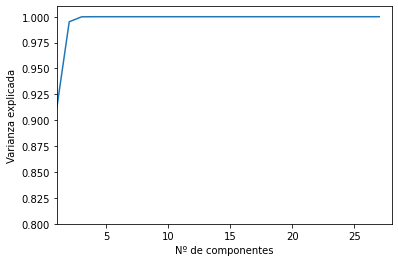

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 28
pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
pca.fit(df)

explained_var = []
for i in range(1, 28):
	explained_var.append(np.sum(pca.explained_variance_ratio_[:i]))

plt.figure()
plt.xlim(1, 28)
plt.ylim(0.8, 1.01)
plt.xlabel('Nº de componentes')
plt.ylabel('Varianza explicada')
plt.plot(range(1, 28), explained_var)
print(explained_var[:4])

In [27]:
pca = PCA(n_components=4, svd_solver="randomized", whiten=True).fit(df.drop(['label'], axis=1))
dfPCA = pca.transform(df.drop(['label'], axis=1))

In [29]:
df.columns

Index(['area', 'momentx', 'momenty', 'label', 'm00', 'm10', 'm01', 'm20',
       'm11', 'm02', 'm30', 'm21', 'm12', 'm03', 'mu20', 'mu11', 'mu02',
       'mu30', 'mu21', 'mu12', 'mu03', 'nu20', 'nu11', 'nu02', 'nu30', 'nu21',
       'nu12', 'nu03'],
      dtype='object')

In [23]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(dfPCA, df['label'])

KNeighborsClassifier(n_neighbors=3)

In [28]:
import joblib

joblib.dump(clf, 'rec_marcas_model.jl')
joblib.dump(pca, 'rec_marcas_pca.jl')

['rec_marcas_pca.jl']

In [21]:
import os

print(os.getcwd())

/Users/manuel/Documents/Universidad/3/Robotica/practica1Robotica-v4.3/codigo_alumnos2021/marcas_rdf


In [18]:
vid = cv2.VideoCapture('proyectoRobotica-1920-line1-video-2020-04-20.avi')
lables = ['flecha', 'man', 'stair', 'telephone', 'woman']

width = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
height =  int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('videoMarcas.avi', fourcc, 30, (width, height))

while True:
	frameo = vid.read()[1]
	frame = frameo.copy()
	maskframe = cv2.inRange(frame, (0, 0, 100), (50, 50, 255))
	frame[maskframe == 0] = [255, 255, 255]

	try:
		contours, ellipse, lkeyp, dess = extract_features(frame)
		if len(contours) != 1:
			contours = contours[0] if cv2.contourArea(contours[0]) > cv2.contourArea(contours[1]) else contours[1]
		M_1 = cv2.moments(contours[0])

		if M_1["m00"] == 0: M_1["m00", "m01"] = 1
		x = int(M_1["m10"] / M_1["m00"])
		y = int(M_1["m01"] / M_1["m00"])
		data = {'momentx': x, 'momenty': y, 'area': cv2.contourArea(contours[0])}
		data.update(M_1)
		odf = pd.DataFrame(columns=columns)
		odf.drop(columns=['label'], inplace=True)
		odf = odf.append(data, ignore_index=True)
		predicted = clf.predict(odf)
		cv2.putText(frame, lables[int(predicted)], (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
		cv2.putText(frameo, lables[int(predicted)], (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
		# print(lables[int(predicted)])
	except IndexError as e:
		cv2.putText(frameo, 'Nothing', (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
	except Exception as e:
		cv2.putText(frameo, 'Nothing', (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

	cv2.imshow('frameo', frameo)
	cv2.imshow('frame', frame)

	video.write(np.uint8(frameo))
	video.write(np.uint8(frameo))
	video.write(np.uint8(frameo))

	cv2.destroyAllWindows()

	if cv2.waitKey(55) & 0xFF == ord('q'):
		break

video.release()
cv2.destroyAllWindows()

AttributeError: 'NoneType' object has no attribute 'copy'